[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreofner/pyGPC/blob/master/demo.ipynb)


In [1]:
!git clone https://github.com/andreofner/pyGPC

Cloning into 'pyGPC'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 126 (delta 16), reused 33 (delta 10), pack-reused 72
Receiving objects: 100% (126/126), 849.53 KiB | 8.85 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [2]:
cd pyGPC

/content/pyGPC


In [6]:
!python GPC.py

100% 21/21 [00:00<00:00, 1534.18it/s]
100% 21/21 [00:00<00:00, 1887.95it/s]
100% 21/21 [00:00<00:00, 2337.71it/s]
100% 21/21 [00:00<00:00, 2187.19it/s]
100% 21/21 [00:00<00:00, 2614.51it/s]


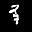

Inputs




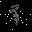

Hierarchical prediction



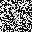

Dynamical prediction



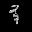

Hierarchical prediction error



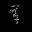

Dynamical prediction error



In [7]:
# run this cell twice if gifs don't show 
from IPython.display import Image, display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
Image(open('./figures/inputs.gif','rb').read())
print("Inputs\n\n")
Image(open('./figures/hier_predictions.gif','rb').read())
print("Hierarchical prediction\n")
Image(open('./figures/trans_predictions.gif','rb').read())
print("Dynamical prediction\n")
Image(open('./figures/hier_errors.gif','rb').read())
print("Hierarchical prediction error\n")
Image(open('./figures/trans_errors.gif','rb').read())
print("Dynamical prediction error\n")